In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
spotify = pd.read_csv('../data/spotify_top_2024.csv', encoding='latin1')
billboard = pd.read_csv('../data/billboard_top.csv', encoding='latin1')

print("Spotify Columns:", spotify.columns.tolist())
print("Billboard Columns:", billboard.columns.tolist())

Spotify Columns: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity', 'Explicit Track']
Billboard Columns: ['chart_week', 'current_week', 'title', 'performer', 'last_week', 'peak_pos', 'wks_on_chart']


In [4]:
spotify.columns = spotify.columns.str.lower().str.replace(' ', '_')
billboard.columns = billboard.columns.str.lower().str.replace(' ', '_')

# Rename Spotify columns for consistency
spotify = spotify.rename(columns={
    'track': 'track',
    'artist': 'artist'
})

billboard = billboard.rename(columns={
    'title': 'track',
    'performer': 'artist'
})

In [5]:
print("Spotify Columns:", spotify.columns.tolist())
print("Billboard Columns:", billboard.columns.tolist())

Spotify Columns: ['track', 'album_name', 'artist', 'release_date', 'isrc', 'all_time_rank', 'track_score', 'spotify_streams', 'spotify_playlist_count', 'spotify_playlist_reach', 'spotify_popularity', 'youtube_views', 'youtube_likes', 'tiktok_posts', 'tiktok_likes', 'tiktok_views', 'youtube_playlist_reach', 'apple_music_playlist_count', 'airplay_spins', 'siriusxm_spins', 'deezer_playlist_count', 'deezer_playlist_reach', 'amazon_playlist_count', 'pandora_streams', 'pandora_track_stations', 'soundcloud_streams', 'shazam_counts', 'tidal_popularity', 'explicit_track']
Billboard Columns: ['chart_week', 'current_week', 'track', 'artist', 'last_week', 'peak_pos', 'wks_on_chart']


In [6]:
import re

def clean_text(s):
    if pd.isna(s):
        return ""
    s = s.lower()
    s = s.strip()

    # remove featuring variations
    s = re.sub(r'\s*\(feat[^\)]*\)', '', s)
    s = re.sub(r'\s*feat\..*', '', s)
    s = re.sub(r'\s*ft\..*', '', s)
    s = re.sub(r'\s*featuring.*', '', s)

    # remove brackets and parentheses like (remix), [remastered], etc.
    s = re.sub(r'\(.*?\)', '', s)
    s = re.sub(r'\[.*?\]', '', s)

    # remove extra spaces
    s = re.sub(r'\s+', ' ', s)

    return s.strip()

# apply to both datasets
for df in [spotify, billboard]:
    df["track"] = df["track"].apply(clean_text)
    df["artist"] = df["artist"].apply(clean_text)

In [7]:
spotify[['track', 'artist']].head(10)
billboard[['track', 'artist']].head(10)

,track,artist
0,all i want for christmas is you,mariah carey
1,rockin' around the christmas tree,brenda lee
2,jingle bell rock,bobby helms
3,a holly jolly christmas,burl ives
4,easy on me,adele
5,it's the most wonderful time of the year,andy williams
6,last christmas,wham!
7,feliz navidad,jose feliciano
8,stay,the kid laroi & justin bieber
9,sleigh ride,the ronettes


In [8]:
features = [
    'spotify_streams',
    'spotify_playlist_count',
    'spotify_playlist_reach',
    'spotify_popularity',
    'youtube_views',
    'youtube_likes',
    'tiktok_posts',
    'tiktok_likes',
    'tiktok_views'
]

def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    
    x = str(x).strip().lower()
    
    # Replace common missing-value placeholders
    if x in ["", "-", "--", "nan", "none"]:
        return np.nan
    
    # Remove commas
    x = x.replace(",", "")
    
    # Remove words like "views"
    x = re.sub(r"[^\d\.]", "", x)
    
    # Extract numbers only
    match = re.search(r"\d+\.?\d*", x)
    if not match:
        return np.nan
    
    return float(match.group())

# Apply to Spotify only (these columns do not appear in Billboard)
for col in features:
    if col in spotify.columns:
        spotify[col] = spotify[col].apply(clean_numeric)

In [9]:
spotify[features].head()
spotify[features].describe()

,spotify_streams,spotify_playlist_count,spotify_playlist_reach,spotify_popularity,youtube_views,youtube_likes,tiktok_posts,tiktok_likes,tiktok_views
count,4.487000e+03,4530.000000,4.528000e+03,3796.000000,4.292000e+03,4.285000e+03,3.427000e+03,3.620000e+03,3.619000e+03
mean,4.473873e+08,59390.829801,2.334682e+07,63.501581,4.027967e+08,2.930049e+06,9.443076e+05,1.126375e+08,1.161158e+09
std,5.384439e+08,71131.406625,2.968717e+07,16.186438,7.019000e+08,4.593640e+06,2.442080e+06,5.498123e+08,5.881584e+09
min,1.071000e+03,1.000000,1.000000e+00,1.000000,9.130000e+02,2.500000e+01,1.000000e+00,3.000000e+00,1.900000e+01
25%,7.038630e+07,6718.000000,4.791612e+06,61.000000,4.073032e+07,4.095490e+05,3.818650e+04,5.814876e+06,5.902786e+07
50%,2.398507e+08,32312.500000,1.325948e+07,67.000000,1.482696e+08,1.257935e+06,1.822000e+05,2.653441e+07,2.659172e+08
75%,6.283638e+08,86038.750000,2.966069e+07,73.000000,4.647882e+08,3.573193e+06,7.948775e+05,9.328418e+07,9.134169e+08
max,4.281469e+09,590392.000000,2.623434e+08,96.000000,1.632276e+10,6.231118e+07,4.290000e+07,2.347422e+10,2.332323e+11


In [10]:
billboard.columns

Index(['chart_week', 'current_week', 'track', 'artist', 'last_week',
       'peak_pos', 'wks_on_chart'],
      dtype='object')

In [11]:
import pandas as pd

# -----------------------------
# 1. CLEAN COLUMN NAMES
# -----------------------------
spotify.columns = spotify.columns.str.lower().str.replace(" ", "_")
billboard.columns = billboard.columns.str.lower().str.replace(" ", "_")

# -----------------------------
# 2. STANDARDIZE TRACK + ARTIST FOR MATCHING
# -----------------------------
for df in [spotify, billboard]:
    df['track'] = df['track'].str.lower().str.strip()
    df['artist'] = df['artist'].str.lower().str.strip()

# -----------------------------
# 3. EXTRACT YEARS
# -----------------------------
spotify['release_year'] = pd.to_datetime(
    spotify['release_date'], errors='coerce'
).dt.year

billboard['chart_year'] = pd.to_datetime(
    billboard['chart_week'], errors='coerce'
).dt.year

# -----------------------------
# 4. FILTER 2024 SONGS
# -----------------------------
spotify_2024 = spotify[spotify['release_year'] == 2024]

billboard_2024 = billboard[billboard['chart_year'] == 2024]

# -----------------------------
# 5. MARK SPOTIFY SONGS THAT CHARTED IN 2024
# -----------------------------
chart_songs_2024 = set(zip(billboard_2024['track'], billboard_2024['artist']))

spotify['charted_2024'] = (
    pd.Series(list(zip(spotify['track'], spotify['artist'])))
    .isin(chart_songs_2024)
)

# -----------------------------
# 6. FINAL DATASET:
# Songs released in 2024 OR charted in 2024
# -----------------------------
spotify_final = spotify[
    (spotify['release_year'] == 2024) | (spotify['charted_2024'])
].copy()

print("Final dataset shape:", spotify_final.shape)
spotify_final.head()

Final dataset shape: (810, 31)


,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,deezer_playlist_reach,amazon_playlist_count,pandora_streams,pandora_track_stations,soundcloud_streams,shazam_counts,tidal_popularity,explicit_track,release_year,charted_2024
0,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,3.904709e+08,30716.0,196631588.0,...,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0,2024,True
1,not like us,Not Like Us,kendrick lamar,5/4/2024,USUG12400910,2,545.9,3.237039e+08,28113.0,174597137.0,...,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1,2024,True
2,i like the way you kiss me,I like the way you kiss me,artemas,3/19/2024,QZJ842400387,3,538.4,6.013093e+08,54331.0,211607669.0,...,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0,2024,True
3,flowers,Flowers - Single,miley cyrus,1/12/2023,USSM12209777,4,444.9,2.031281e+09,269802.0,136569078.0,...,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0,2023,True
4,houdini,Houdini,eminem,5/31/2024,USUG12403398,5,423.3,1.070349e+08,7223.0,151469874.0,...,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1,2024,False


In [12]:
final = spotify_final.merge(
    billboard_2024[['track', 'artist', 'current_week', 'peak_pos', 'wks_on_chart']],
    on=['track', 'artist'],
    how='left'
)

In [13]:
final['charted'] = final['current_week'].notna().astype(int)

final['peak_pos'] = final['peak_pos'].fillna(200)       # assume 200 = “did not chart”
final['wks_on_chart'] = final['wks_on_chart'].fillna(0) # no weeks on chart

In [14]:
print(final.shape)
final.head()

(2625, 35)


,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,soundcloud_streams,shazam_counts,tidal_popularity,explicit_track,release_year,charted_2024,current_week,peak_pos,wks_on_chart,charted
0,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,390470936.0,30716.0,196631588.0,...,"4,818,457","2,669,262",NaN,0,2024,True,2.0,2.0,1.0,1
1,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,390470936.0,30716.0,196631588.0,...,"4,818,457","2,669,262",NaN,0,2024,True,2.0,2.0,2.0,1
2,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,390470936.0,30716.0,196631588.0,...,"4,818,457","2,669,262",NaN,0,2024,True,3.0,2.0,3.0,1
3,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,390470936.0,30716.0,196631588.0,...,"4,818,457","2,669,262",NaN,0,2024,True,3.0,2.0,4.0,1
4,million dollar baby,Million Dollar Baby - Single,tommy richman,4/26/2024,QM24S2402528,1,725.4,390470936.0,30716.0,196631588.0,...,"4,818,457","2,669,262",NaN,0,2024,True,3.0,2.0,5.0,1


In [15]:
print("Final dataset shape:", final.shape)
print(final.info())
final.describe(include='all')

Final dataset shape: (2625, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   track                       2625 non-null   object 
 1   album_name                  2625 non-null   object 
 2   artist                      2625 non-null   object 
 3   release_date                2625 non-null   object 
 4   isrc                        2625 non-null   object 
 5   all_time_rank               2625 non-null   object 
 6   track_score                 2625 non-null   float64
 7   spotify_streams             2582 non-null   float64
 8   spotify_playlist_count      2579 non-null   float64
 9   spotify_playlist_reach      2578 non-null   float64
 10  spotify_popularity          1519 non-null   float64
 11  youtube_views               2097 non-null   float64
 12  youtube_likes               2097 non-null   float64
 13  t

,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,soundcloud_streams,shazam_counts,tidal_popularity,explicit_track,release_year,charted_2024,current_week,peak_pos,wks_on_chart,charted
count,2625,2625,2625,2625,2625,2625,2625.000000,2.582000e+03,2579.000000,2.578000e+03,...,1196,2110,0.0,2625.000000,2625.000000,2625,2058.000000,2625.000000,2625.000000,2625.000000
unique,756,674,509,198,810,810,NaN,NaN,NaN,NaN,...,277,663,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,greedy,THE TORTURED POETS DEPARTMENT,taylor swift,4/18/2024,USRV82300987,"2,913",NaN,NaN,NaN,NaN,...,"5,597,165","10,517,831",NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
freq,69,99,161,104,23,23,NaN,NaN,NaN,NaN,...,23,23,NaN,NaN,NaN,2058,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,82.063429,3.446774e+08,28515.273750,4.839320e+07,...,NaN,NaN,NaN,0.417143,2023.371048,NaN,43.548591,62.055238,11.616000,0.784000
std,NaN,NaN,NaN,NaN,NaN,NaN,90.868471,4.158652e+08,41384.871029,5.786419e+07,...,NaN,NaN,NaN,0.493181,1.105453,NaN,28.331770,75.795434,13.116518,0.411593
min,NaN,NaN,NaN,NaN,NaN,NaN,19.400000,3.589000e+03,1.000000,1.000000e+00,...,NaN,NaN,NaN,0.000000,1994.000000,NaN,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,28.800000,6.035561e+07,3273.000000,6.690589e+06,...,NaN,NaN,NaN,0.000000,2023.000000,NaN,19.000000,5.000000,1.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,47.500000,1.702003e+08,11118.000000,2.116666e+07,...,NaN,NaN,NaN,0.000000,2024.000000,NaN,40.000000,24.000000,7.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,98.500000,5.096531e+08,28857.000000,7.057301e+07,...,NaN,NaN,NaN,1.000000,2024.000000,NaN,67.000000,79.000000,18.000000,1.000000


In [16]:
final.isna().sum().sort_values(ascending=False)

tidal_popularity              2625
soundcloud_streams            1429
tiktok_posts                  1383
spotify_popularity            1106
tiktok_views                  1038
tiktok_likes                  1038
siriusxm_spins                1015
youtube_playlist_reach         863
pandora_track_stations         602
pandora_streams                573
current_week                   567
youtube_views                  528
youtube_likes                  528
shazam_counts                  515
deezer_playlist_count          480
deezer_playlist_reach          480
amazon_playlist_count          445
airplay_spins                  277
apple_music_playlist_count     221
spotify_playlist_reach          47
spotify_playlist_count          46
spotify_streams                 43
explicit_track                   0
release_year                     0
charted_2024                     0
peak_pos                         0
wks_on_chart                     0
track                            0
album_name          

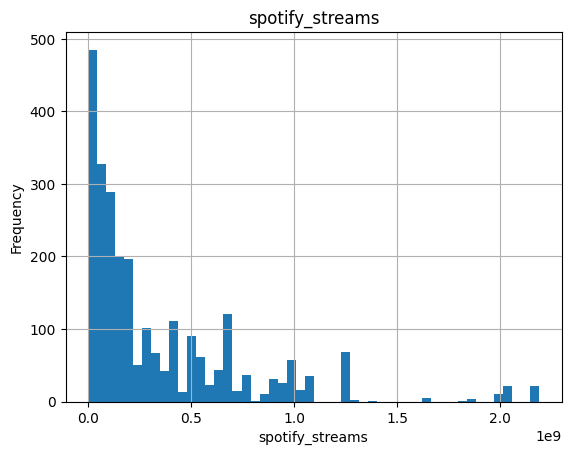

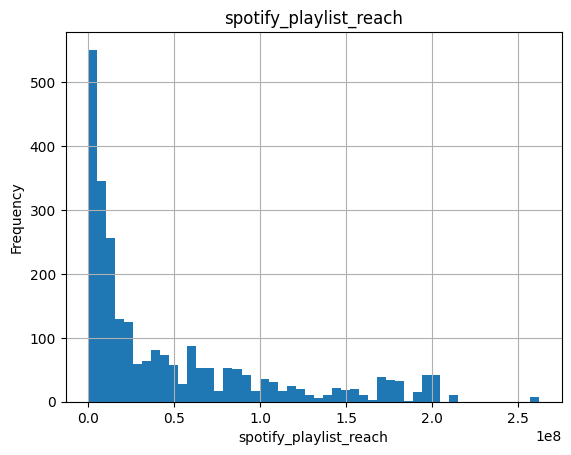

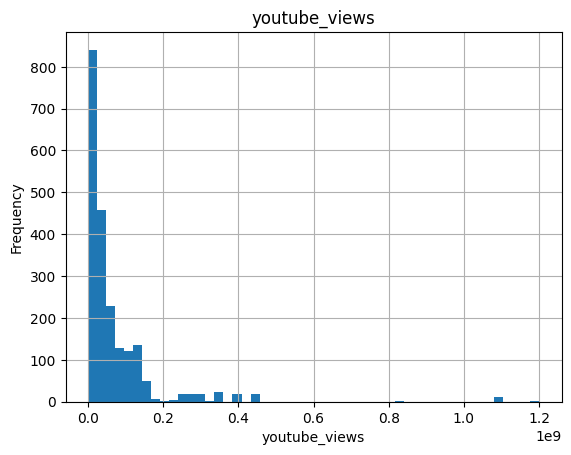

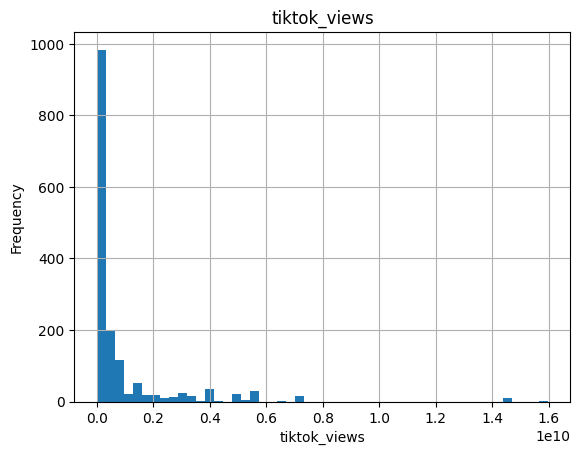

In [17]:
import matplotlib.pyplot as plt

cols_to_plot = [
    'spotify_streams', 'spotify_playlist_reach',
    'youtube_views', 'tiktok_views'
]

for col in cols_to_plot:
    final[col].dropna().hist(bins=50)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

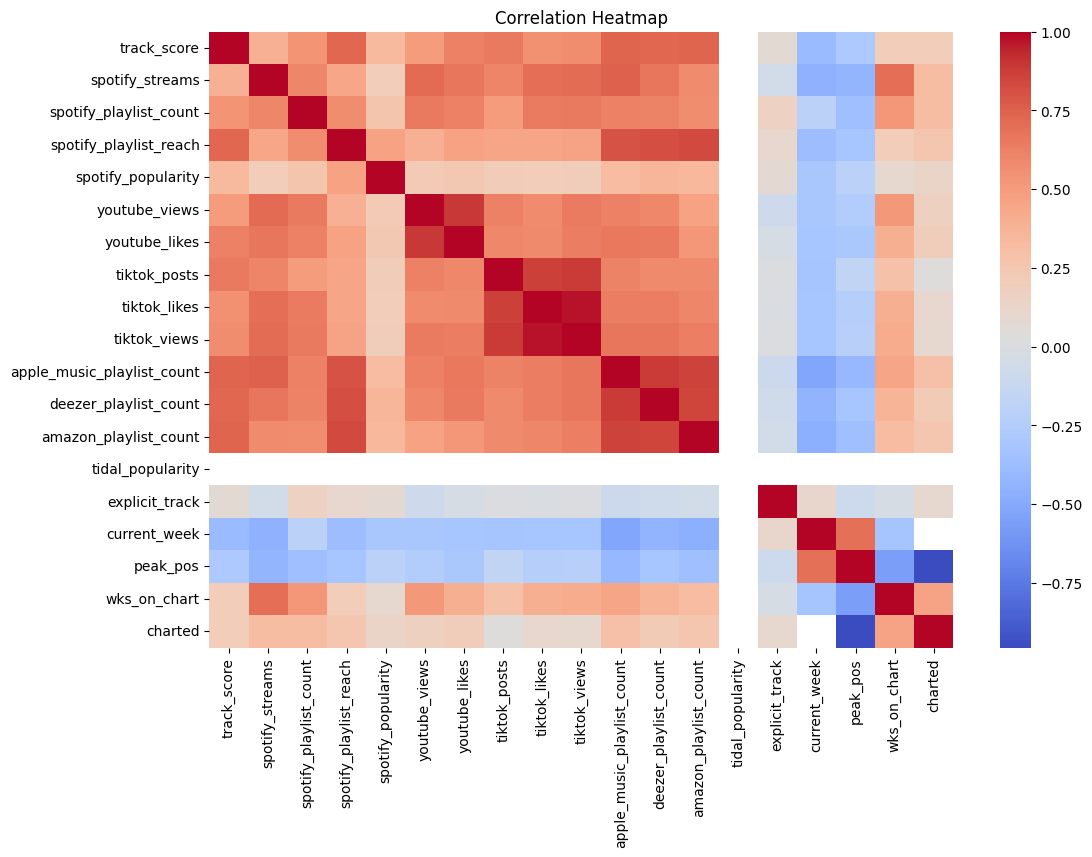

In [18]:
numeric_cols = final.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

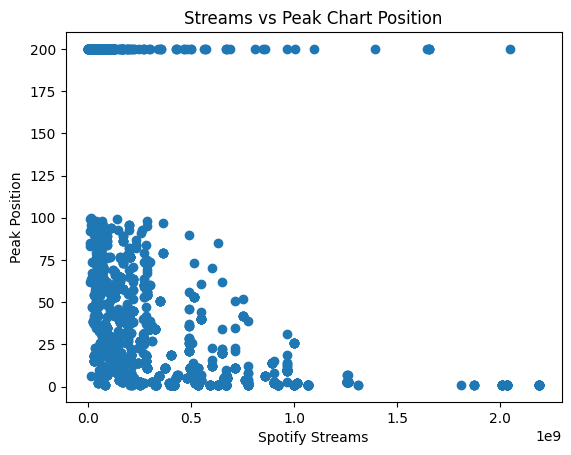

In [19]:
plt.scatter(final['spotify_streams'], final['peak_pos'])
plt.xlabel("Spotify Streams")
plt.ylabel("Peak Position")
plt.title("Streams vs Peak Chart Position")
plt.show()

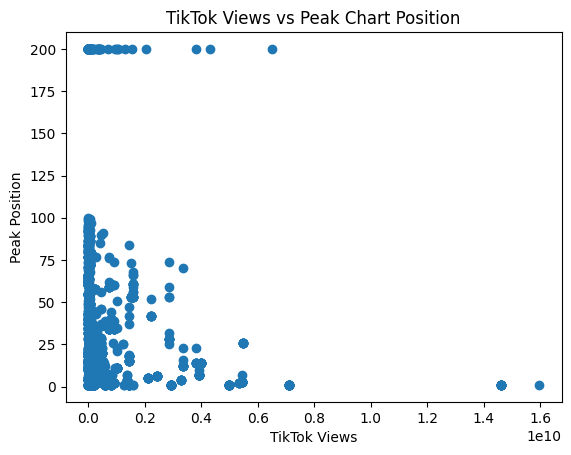

In [20]:
plt.scatter(final['tiktok_views'], final['peak_pos'])
plt.xlabel("TikTok Views")
plt.ylabel("Peak Position")
plt.title("TikTok Views vs Peak Chart Position")
plt.show()

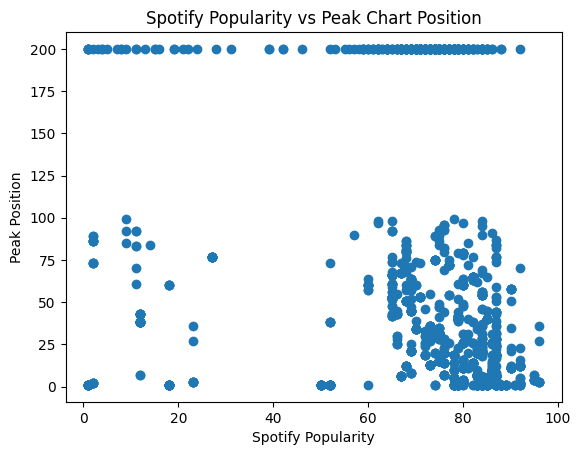

In [21]:
plt.scatter(final['spotify_popularity'], final['peak_pos'])
plt.xlabel("Spotify Popularity")
plt.ylabel("Peak Position")
plt.title("Spotify Popularity vs Peak Chart Position")
plt.show()

In [22]:
print("Final dataset shape:", final.shape)
print(final.info())
final.describe(include='all')

Final dataset shape: (2625, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   track                       2625 non-null   object 
 1   album_name                  2625 non-null   object 
 2   artist                      2625 non-null   object 
 3   release_date                2625 non-null   object 
 4   isrc                        2625 non-null   object 
 5   all_time_rank               2625 non-null   object 
 6   track_score                 2625 non-null   float64
 7   spotify_streams             2582 non-null   float64
 8   spotify_playlist_count      2579 non-null   float64
 9   spotify_playlist_reach      2578 non-null   float64
 10  spotify_popularity          1519 non-null   float64
 11  youtube_views               2097 non-null   float64
 12  youtube_likes               2097 non-null   float64
 13  t

,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,soundcloud_streams,shazam_counts,tidal_popularity,explicit_track,release_year,charted_2024,current_week,peak_pos,wks_on_chart,charted
count,2625,2625,2625,2625,2625,2625,2625.000000,2.582000e+03,2579.000000,2.578000e+03,...,1196,2110,0.0,2625.000000,2625.000000,2625,2058.000000,2625.000000,2625.000000,2625.000000
unique,756,674,509,198,810,810,NaN,NaN,NaN,NaN,...,277,663,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,greedy,THE TORTURED POETS DEPARTMENT,taylor swift,4/18/2024,USRV82300987,"2,913",NaN,NaN,NaN,NaN,...,"5,597,165","10,517,831",NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
freq,69,99,161,104,23,23,NaN,NaN,NaN,NaN,...,23,23,NaN,NaN,NaN,2058,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,82.063429,3.446774e+08,28515.273750,4.839320e+07,...,NaN,NaN,NaN,0.417143,2023.371048,NaN,43.548591,62.055238,11.616000,0.784000
std,NaN,NaN,NaN,NaN,NaN,NaN,90.868471,4.158652e+08,41384.871029,5.786419e+07,...,NaN,NaN,NaN,0.493181,1.105453,NaN,28.331770,75.795434,13.116518,0.411593
min,NaN,NaN,NaN,NaN,NaN,NaN,19.400000,3.589000e+03,1.000000,1.000000e+00,...,NaN,NaN,NaN,0.000000,1994.000000,NaN,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,28.800000,6.035561e+07,3273.000000,6.690589e+06,...,NaN,NaN,NaN,0.000000,2023.000000,NaN,19.000000,5.000000,1.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,47.500000,1.702003e+08,11118.000000,2.116666e+07,...,NaN,NaN,NaN,0.000000,2024.000000,NaN,40.000000,24.000000,7.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,98.500000,5.096531e+08,28857.000000,7.057301e+07,...,NaN,NaN,NaN,1.000000,2024.000000,NaN,67.000000,79.000000,18.000000,1.000000


In [23]:
feature_cols = [
    'spotify_streams',
    'spotify_popularity',
    'spotify_playlist_reach',
    'spotify_playlist_count',
    'youtube_views',
    'tiktok_views',
    'tiktok_likes',
    'tiktok_posts'
]

X = final[feature_cols]
y = final['peak_pos']

X = X.fillna(X.mean())



In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
y_pred = lr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

importance = pd.Series(lr.coef_, index=X.columns)
importance.sort_values(ascending=False)

MAE: 53.322354482644045
RMSE: 63.8253047829793
R²: 0.22339948749422445


tiktok_views              18.346562
youtube_views              3.453069
tiktok_likes               1.094077
tiktok_posts              -0.400531
spotify_popularity        -2.946712
spotify_playlist_reach    -8.450279
spotify_playlist_count   -17.390436
spotify_streams          -31.083178
dtype: float64

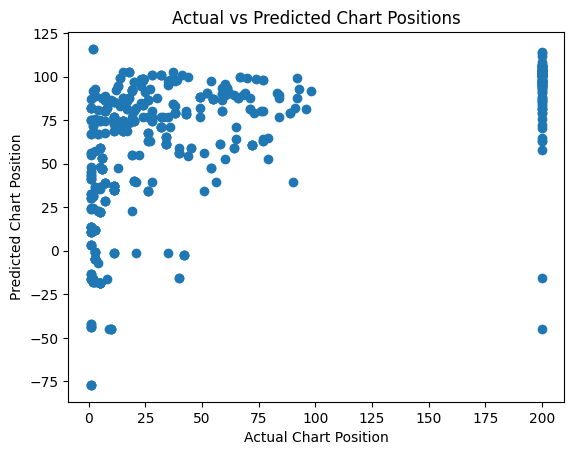

In [30]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Chart Position")
plt.ylabel("Predicted Chart Position")
plt.title("Actual vs Predicted Chart Positions")
plt.show()

In [20]:
///

# Ensure chart_week is a datetime column
billboard['chart_week'] = pd.to_datetime(billboard['chart_week'], errors='coerce')

# Extract the year from the date
billboard['year'] = billboard['chart_week'].dt.year

# Filter to keep only songs that appeared on Billboard in 2024
billboard_2024 = billboard[billboard['year'] == 2024].copy()

In [21]:
merged = pd.merge(
    spotify,
    billboard_2024[['title', 'performer', 'peak_pos', 'wks_on_chart']],
    on=['title', 'performer'],
    how='inner'  # only keep songs that appear in both
)

In [22]:
features = [
    'spotify streams', 'spotify playlist count', 'spotify playlist reach',
    'spotify popularity', 'youtube views', 'youtube likes',
    'tiktok posts', 'tiktok likes', 'tiktok views'
]

# Clean numeric columns
for col in features:
    if col in merged.columns:
        merged[col] = (
            merged[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.replace('-', '0', regex=False)
            .str.extract('(\d+\.?\d*)')[0]
            .astype(float)
        )

# Create scaled version for plotting
merged['spotify_streams_100m'] = merged['spotify streams'] / 100_000_000

# Drop NaNs
merged = merged.dropna(subset=features + ['spotify_streams_100m', 'peak_pos'])

merged[features].describe()

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/var/folders/8v/g4l9gxvd0q7f6kf8_2r2wdj40000gn/T/ipykernel_54273/2886193718.py:15: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+\.?\d*)')[0]


,spotify streams,spotify playlist count,spotify playlist reach,spotify popularity,youtube views,youtube likes,tiktok posts,tiktok likes,tiktok views
count,7.400000e+02,740.000000,7.400000e+02,740.000000,7.400000e+02,7.400000e+02,7.400000e+02,7.400000e+02,7.400000e+02
mean,5.186379e+08,57263.287838,8.358388e+07,75.663514,1.053981e+08,1.105083e+06,8.304959e+05,1.291203e+08,1.432825e+09
std,4.856672e+08,51088.765395,7.033496e+07,17.432849,1.479874e+08,1.458194e+06,1.570160e+06,2.107068e+08,2.436161e+09
min,1.029272e+07,1666.000000,3.644016e+06,2.000000,5.174500e+04,4.110000e+02,1.740000e+02,4.057000e+03,3.820000e+04
25%,1.702003e+08,17900.000000,1.385020e+07,73.000000,2.775878e+07,2.416410e+05,4.153875e+04,3.392242e+06,4.504770e+07
50%,3.505842e+08,32825.000000,7.071422e+07,80.000000,6.689388e+07,6.005510e+05,1.008930e+05,3.517607e+07,3.866100e+08
75%,7.501550e+08,98450.000000,1.504710e+08,85.000000,1.311481e+08,1.504385e+06,4.952000e+05,1.724381e+08,1.726707e+09
max,2.188247e+09,269802.000000,2.623434e+08,95.000000,1.096101e+09,1.062980e+07,1.889472e+07,1.432228e+09,1.596313e+10


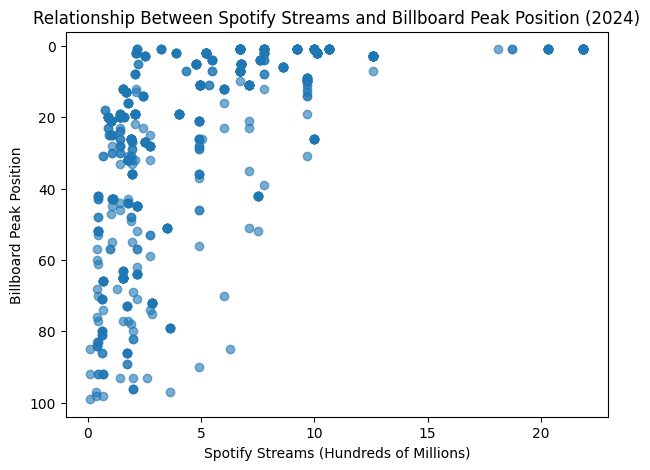

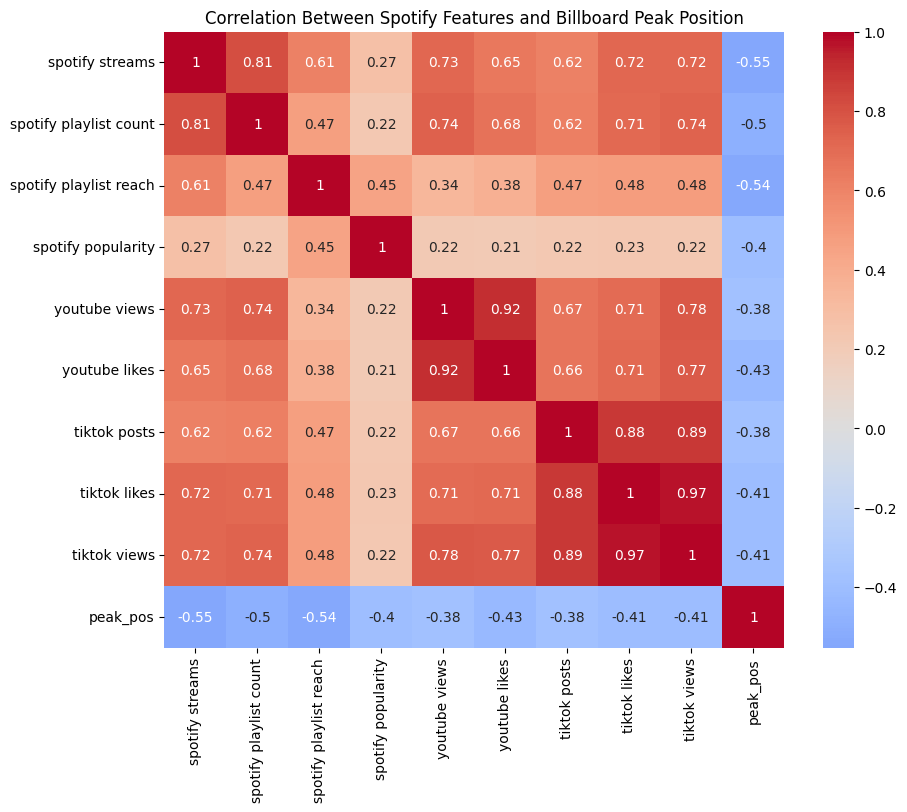

In [23]:
plt.figure(figsize=(7, 5))
plt.scatter(merged['spotify_streams_100m'], merged['peak_pos'], alpha=0.6)
plt.xlabel('Spotify Streams (Hundreds of Millions)')
plt.ylabel('Billboard Peak Position')
plt.title('Relationship Between Spotify Streams and Billboard Peak Position (2024)')
plt.gca().invert_yaxis()
plt.show()


corr = merged[features + ['peak_pos']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Spotify Features and Billboard Peak Position')
plt.show()


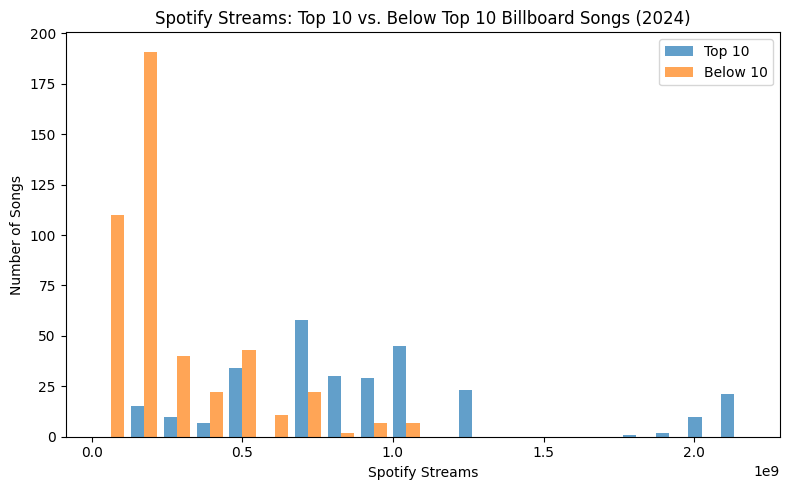

In [74]:
# Separate songs by chart performance
top10 = merged[merged['peak_pos'] <= 10]['spotify streams'].dropna()
below10 = merged[merged['peak_pos'] > 10]['spotify streams'].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist([top10, below10], bins=20, label=['Top 10', 'Below 10'], alpha=0.7)
plt.xlabel('Spotify Streams')
plt.ylabel('Number of Songs')
plt.title('Spotify Streams: Top 10 vs. Below Top 10 Billboard Songs (2024)')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
X = merged[features]
y = merged['peak_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

R² Score: 0.40652599712042536
Mean Absolute Error: 15.935152038277284


/tmp/ipython-input-261122721.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=importance, palette='viridis')


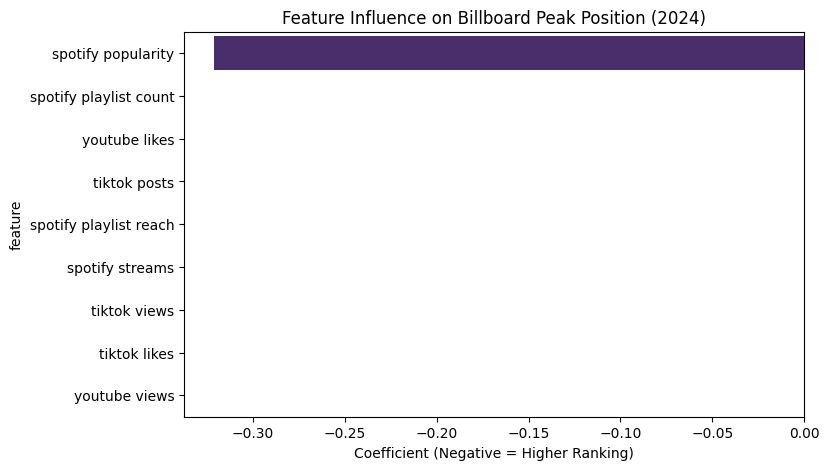

In [73]:
importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
}).sort_values(by='coefficient')

plt.figure(figsize=(8, 5))
sns.barplot(x='coefficient', y='feature', data=importance, palette='viridis')
plt.title('Feature Influence on Billboard Peak Position (2024)')
plt.xlabel('Coefficient (Negative = Higher Ranking)')
plt.show()